<a href="https://colab.research.google.com/github/wiumjolene/wellmum/blob/main/wellmum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wellmum Clinic Data Analysis


This notebook explores data originating out of the Wellmum post natal clinic. The clinic is used as a follow-up of patients who gave birth in the past 6 months.

This document aims to answer the following questions:

1. Population description: Age, race, parity
2. Describe Creatinine > 80
3. Describe eGFR <90
4. Describe ALT >40
5. Describe Hb <120
6. Describe ACR >3
7. HbA1C <39, 39-47, >48
8. Correlation between MUAC and current BMI and waist circumference
9. Correlation between random glucose and HbA1C
10. Relationship between eGFR >90 and ACR >3
11. Relationship between ALT >40 and HbA1C >39
12. Relationship between eGFR <90 and HbA1C >39

### Prepare data
* Data from the Wellmum dataset is imported 
* Rows with data errors are excluded for the dataset
* Columns are renamed to `friendly' names for easy access in this notebook
* Categorical data, such as `Race' are cleaned in the code 

In [1209]:
# Import libraries
# General
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
# import plotly.io as pio

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, r2_score
import statsmodels.api as sm

# Import data and print the shape of the data
df_import = pd.read_excel("WELLMUM_20230609.xlsx")

df = df_import[df_import['Remove'] != 1]

# Rename columns
df = df.rename(columns={'Gravidity (how many pregnancies have you had?)': 'Gravidity',
                        'Parity (number of live births)': 'Parity',
                        'random glucose': 'RandomGlucose',
                        'AGE': 'Age',
                        'Weight (kg)': 'Weight',
                        'Mid upper arm circumstance ': 'MUAC',
                        'ID ': 'Id',
                        'Current BMI': 'BMI',
                        'GDM control': 'GDMControl',
                        'Maternal date of birth': 'MDOB',
                        'Problems during pregnancy': 'Problems'})

# # Select subset of columns
cols = ['Id', 'Age', 'Gravidity', 'Parity', 'BMI', 'Weight', 'Creatinine',
        'HbA1C', 'ACR', 'GDMControl', 'Race', 'RandomGlucose', 'eGFR', 'ALT',
        'MUAC', 'Hb', 'MDOB', 'Breastfeeding']
df = df[cols]

# Clean Race
df['Race'] = df['Race'].str.upper()
df['Race'] = df['Race'].str.strip()
df.loc[(df['Race'] == 'ASIAN'), 'Race'] = 'ASIAN'
df.loc[(df['Race'] == 'EAST ASIAN'), 'Race'] = 'ASIAN'
df.loc[(df['Race'] == 'SOUTH ASIAN'), 'Race'] = 'ASIAN'

# Clean 'Breastfeeding'
df['Breastfeeding'] = df['Breastfeeding'].str.upper()
df['Breastfeeding'] = df['Breastfeeding'].str.strip()

df['BMI'] = df['BMI'].round(2)
df['HbA1C'] = df['HbA1C'].astype(float)

print(f"""Data consits of {len(df)} rows after cleaning. 
* {len(df_import)-len(df)} rows have been excluded.
      """)

# pio.templates.default = "none"
themes = ['ggplot2', 'seaborn', 'simple_white', 'plotly',
          'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
          'ygridoff', 'gridon', 'none']

Data consits of 219 rows after cleaning. 
* 4 rows have been excluded.
      


In [1210]:
# Set theme colours
COLOURS = {
    0: '#191c40',
    1: '#404472',
    2: '#5c5f7c',
    3: '#c3c0c0',
    10: '#b29758',
}
PLOTBACKGROUND = 'white'
GRIDCOLOUR = 'lightgrey'

## **Descriptive statistics**

### Polulation age

In [1211]:
df.loc[df['Age'] < 35, 'AgeCat'] = '< 35'
df.loc[(df['Age'] > 35) & (df['Age'] <= 40), 'AgeCat'] = '35-40'
df.loc[(df['Age'] > 40) & (df['Age'] <= 45), 'AgeCat'] = '40-45'
df.loc[df['Age'] > 45, 'AgeCat'] = '> 45'

age = df.groupby(['AgeCat', 'Race']).size().reset_index(name='Counts')

age.loc[age['AgeCat'] == '< 35', 'Sort'] = 10
age.loc[age['AgeCat'] == '35-40', 'Sort'] = 20
age.loc[age['AgeCat'] == '40-45', 'Sort'] = 30
age.loc[age['AgeCat'] == '> 45', 'Sort'] = 40

age = age.sort_values(by=['Sort'])
age['Percentage'] = round(age['Counts'] / len(df) * 100, 2)

fig = go.Figure()

for count, race in enumerate(df.Race.unique()):
    aget = age[age['Race'] == race]
    fig.add_trace(go.Bar(x=aget['AgeCat'],
                         y=aget['Percentage'],
                         text=aget['Percentage'],
                         marker_color=COLOURS[count],
                         name=race))

fig.update_layout(
    title=go.layout.Title(
        text=f"Age distribution<br><sup><i>(n={len(df)})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Age<br><sup><i>years</i></sup>"
        ),
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Percentage<br><sup><i>%</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    ),
    barmode='stack'
)
fig.show()
fig.write_image("images/ages.jpeg")

In [1212]:
df.loc[df['BMI'] <= 18, 'BMICat'] = '< 18'
df.loc[(df['BMI'] > 18) & (df['BMI'] <= 25), 'BMICat'] = '18-25'
df.loc[(df['BMI'] > 25) & (df['BMI'] <= 30), 'BMICat'] = '25-30'
df.loc[(df['BMI'] > 30) & (df['BMI'] <= 35), 'BMICat'] = '30-35'
df.loc[df['BMI'] > 35, 'BMICat'] = '> 35'

dft = df.groupby(['BMICat', 'Race']).size().reset_index(name='Counts')

dft.loc[dft['BMICat'] == '< 18', 'Sort'] = 10
dft.loc[dft['BMICat'] == '18-25', 'Sort'] = 20
dft.loc[dft['BMICat'] == '25-30', 'Sort'] = 30
dft.loc[dft['BMICat'] == '30-35', 'Sort'] = 40
dft.loc[dft['BMICat'] == '> 35', 'Sort'] = 40

dft = dft.sort_values(by=['Sort'])
dft['Percentage'] = round(age['Counts'] / len(df) * 100, 2)

fig = go.Figure()

for count, race in enumerate(df.Race.unique()):
    dftt = dft[dft['Race'] == race]
    fig.add_trace(go.Bar(x=dftt['BMICat'],
                         y=dftt['Percentage'],
                         text=dftt['Percentage'],
                         marker_color=COLOURS[count],
                         name=race))

fig.update_layout(
    title=go.layout.Title(
        text=f"BMI distribution<br><sup><i>(n={len(df)})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="BMI<br><sup><i>body mass index</i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Percentage<br><sup><i>%</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    ),
    barmode='stack'
)
fig.show()
fig.write_image("images/bmi.jpeg")

### Population race

In [1213]:
# @title
race = df.groupby(['Race']).size().reset_index(name='Counts')
race = race.sort_values(by=['Counts'], ascending=False)

fig = go.Figure([go.Bar(x=race['Race'],
                        y=race['Counts'],
                        marker_color=list(COLOURS.values()),
                        text=race['Counts'])])
fig.update_layout(
    title=go.layout.Title(
        text=f"Race distribution<br><sup><i>(n={len(df)})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Race"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Count"
        ),
        gridcolor=GRIDCOLOUR
    )
)
fig.show()
fig.write_image("images/race.jpeg")

### Population parity

In [1214]:
# @title
par = df.groupby(['Parity']).size().reset_index(name='Counts')

par['Percentage'] = round(par['Counts']/par['Counts'].sum() * 100)

fig = go.Figure([go.Bar(x=par['Parity'],
                        y=par['Percentage'],
                        marker_color=COLOURS[0],
                        text=par['Percentage'])])

fig.update_layout(
    title=go.layout.Title(
        text=f"Parity distribution<br><sup><i>(n={len(df)})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Parity<br><sup><i>number of live births</i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Percentage<br><sup><i>%</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    ),

)
fig.show()
fig.write_image("images/parity.jpeg")

In [1215]:
# @title
par = df.groupby(['Parity', 'Race']).size().reset_index(name='Counts')

fig = go.Figure()
for count, var in enumerate(par.Race.unique()):
    dft = par[par['Race'] == var].reset_index(drop=True)
    dft['Percentage'] = round(dft['Counts']/par['Counts'].sum() * 100)
    text = round(dft['Counts']/par['Counts'].sum() * 100)
    fig.add_trace(go.Bar(x=dft['Parity'], y=dft['Percentage'],
                  name=var, marker_color=COLOURS[count], text=text))

fig.update_layout(
    title=go.layout.Title(
        text=f"Parity distribution by Race<br><sup><i>(n={len(df)})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Parity<br><sup><i>number of live births</i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Percentage<br><sup><i>%</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    ),
    barmode='stack',
)
fig.show()
fig.write_image("images/parity-race.jpeg")

In [1216]:
# @title
par = df.groupby(['Parity', 'Breastfeeding']).size().reset_index(name='Counts')

fig = go.Figure()
for var in par.Breastfeeding.unique():
    if var == 'YES':
        colour = COLOURS[0]

    else:
        colour = COLOURS[3]

    dft = par[par['Breastfeeding'] == var].reset_index(drop=True)
    dft['Percentage'] = round(dft['Counts']/par['Counts'].sum() * 100)
    text = round(dft['Counts']/par['Counts'].sum() * 100)
    fig.add_trace(go.Bar(x=dft['Parity'], y=dft['Percentage'],
                  name=var, marker_color=colour, text=text))

fig.update_layout(
    title=go.layout.Title(
        text=f"Parity distribution by Breastfeeding<br><sup><i>(n={len(df)})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Parity<br><sup><i>number of live births</i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Percentage<br><sup><i>%</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    ),
    barmode='stack',
)
fig.show()
fig.write_image("images/parity-breastfeeding.jpeg")

## **Correlations**


In [1217]:
# @title
columns = ['HbA1C', 'BMI', 'MUAC', 'Creatinine',
           'ALT', 'eGFR', 'RandomGlucose']
values = []

for x in columns:
    vals = []
    for y in columns:
        corr = round(df[x].corr(df[y]), 4)
        vals.append(corr)
    values.append(vals)

fig = go.Figure(data=go.Heatmap(
    z=values,
    x=columns,
    y=columns,
    text=values,
    texttemplate="%{text}",
    hoverongaps=True, 
    colorscale = 'RdBu_r'))

fig.update_layout(
    # title='Creatinine > 80',
    title=f"Correlation matrix<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
)

fig.show()
fig.write_image("images/correlation-matrix.jpeg")

### MUAC vs BMI by Race

In [1218]:
# @title
fig = go.Figure()

for count, race in enumerate(df.Race.unique()):
    dft = df[df['Race'] == race]
    name = f"{race}<br><sup><i>(n={len(dft)})</i></sup>"
    fig.add_trace(go.Box(y=dft['BMI'],
                         name=name,
                         notched=True,
                         jitter=0.3,
                         marker_color=COLOURS[count],
                         pointpos=-1.8,
                         boxpoints='all',  # represent all points
                         ))

fig.add_trace(go.Box(y=df['BMI'],
                     name=f"All<br><sup><i>(n={len(df)})</i></sup>",
                     notched=True,
                     jitter=0.3,
                     marker_color=COLOURS[10],
                     pointpos=-1.8,
                     boxpoints='all',  # represent all points
                     ))

fig.update_layout(
    title=f"BMI spread by Race<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="BMI"
        ),
        gridcolor=GRIDCOLOUR
    )
)


fig.show()
fig.write_image("images/bmi-race.jpeg")

In [1219]:
# @title
fig = go.Figure()
corra = round(df['BMI'].corr(df['MUAC']), 4)

for count, race in enumerate(df.Race.unique()):
    dft = df[df['Race'] == race]
    corr = round(dft['BMI'].corr(dft['MUAC']), 4)
    name = f"{race}<br><sup><i>(correlation={corr})</i></sup>"

    fig.add_trace(go.Scatter(
        x=dft['BMI'], y=dft['MUAC'],
        name=name,
        marker_color=COLOURS[count],
        mode='markers',
    ))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=0.3, marker_size=10)

fig.update_layout(
    title=go.layout.Title(
        text=f"MUAC vs BMI<br><sup><i>(correlation={corra})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="BMI<br><sup><i>Body Mass Index</i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="MUAC<br><sup><i>Mid Upper Arm Circumference</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)


fig.show()
fig.write_image("images/bmi-muac.jpeg")

### Random Glucose vs HbA1C

In [1220]:
# @title
fig = go.Figure()
corra = round(df['RandomGlucose'].corr(df['HbA1C']), 4)

for count, race in enumerate(df.Race.unique()):
    dft = df[df['Race'] == race]
    dft = dft[dft['HbA1C'] >= 18]
    dft = dft[dft['HbA1C'] <= 50]
    corr = round(dft['RandomGlucose'].corr(dft['HbA1C']), 4)
    name = f"{race}<br><sup><i>(correlation={corr})</i></sup>"

    fig.add_trace(go.Scatter(
        x=dft['RandomGlucose'], y=dft['HbA1C'],
        name=name,
        marker_color=COLOURS[count],
        mode='markers',
    ))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=0.3, marker_size=10)

fig.update_layout(
    title=go.layout.Title(
        text=f"HbA1C vs Random Glucose<br><sup><i>(correlation={corra})</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Random Glucose<br><sup><i> </i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="HbA1C<br><sup><i>%</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)


fig.show()
fig.write_image("images/hba1c-rg.jpeg")

#### Predicting HbA1C

Can HbA1C be predicted by the other variables in the data set?



Linear Regression to determine if HbA1C can be predicted by a subset of data.

* `RandomGlucose', 
* `BMI', 
* `MUAC', 
* `eGFR', 
* `Hb', 
* `Race'

In [1221]:
df_reg = df[['RandomGlucose', 'BMI', 'MUAC', 'eGFR', 'Hb', 'HbA1C', 'Race']]
df_reg = df_reg.dropna()

y = pd.get_dummies(df_reg.Race, prefix='R')
df_reg = pd.merge(df_reg, y, left_index=True, right_index=True)
df_reg = df_reg.drop(columns=['Race'])

cols = list(df_reg.columns)
cols.remove('HbA1C')

x = df_reg[cols]
y = df_reg['HbA1C']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x)  # adding a constant

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

Intercept: 
 23.08849662313321
Coefficients: 
 [ 0.38063133  0.08458499  0.04945088 -0.00526465  0.06777353  0.65250515
  0.0102763   0.5628528  -1.22563425]
                            OLS Regression Results                            
Dep. Variable:                  HbA1C   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.460
Date:                Mon, 12 Jun 2023   Prob (F-statistic):              0.174
Time:                        22:36:29   Log-Likelihood:                -648.16
No. Observations:                 214   AIC:                             1314.
Df Residuals:                     205   BIC:                             1345.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      

SkiKit Learn decision tree regressor to determine if HbA1C can be predicted by a subset of data.

* `RandomGlucose', 
* `BMI', 
* `MUAC', 
* `eGFR', 
* `Hb', 
* `Race'

(160, 9) (54, 9)
Accuracy score of the tree = 5.56%


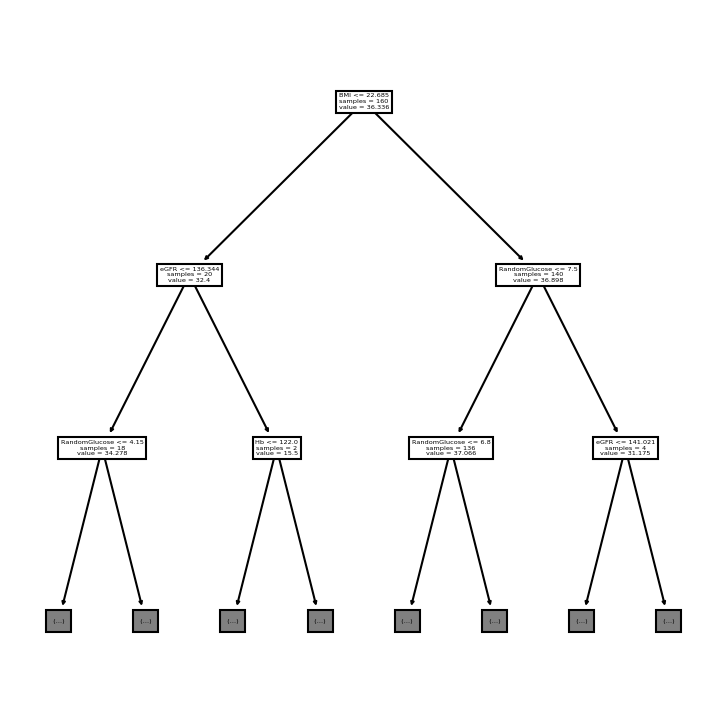

In [1222]:
df_reg = df[['RandomGlucose', 'BMI', 'MUAC', 'eGFR', 'Hb', 'HbA1C', 'Race']]
df_reg = df_reg.dropna()

y = pd.get_dummies(df_reg.Race, prefix='R')
df_reg = pd.merge(df_reg, y, left_index=True, right_index=True)
df_reg = df_reg.drop(columns=['Race'])
# print(df_reg)

cols = list(df_reg.columns)
cols.remove('HbA1C')

X = df_reg[cols]
y = df_reg['HbA1C']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

# Fit data to tree-based regression model
regressor = DecisionTreeRegressor(random_state=2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# Accuracy scores
test_score = accuracy_score(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
print("Accuracy score of the tree = {:2.2%}".format(test_score))

# Visualising the decision tree regression results
plt.figure(figsize=(6, 6), dpi=150)
plot_tree(regressor, max_depth=2, feature_names=X.columns, impurity=False)
plt.show()

Regression analysis shows HbA1C can not be used to determine HbA1C.

## **Creatinine > 80**
Creatinine is an important indicator of kidney health, because it is an easily measured byproduct of muscle metabolism that is excreted unchanged by the kidneys.

### Overview
This figure shows the spread of `Creatinine > 80' in the population.

In [1223]:
# Creatinine>90
df["Creat80"] = 0
df.loc[df['Creatinine'] > 80, 'Creat80'] = 1
sumc = df["Creat80"].sum()

fig = go.Figure()

for tra in [0, 1]:
    dft = df[df['Creat80'] == tra]

    if tra == 0:
        name = 'Creatinine <= 80'
        col = COLOURS[0]

    else:
        name = 'Creatinine >  80'
        col = COLOURS[10]

    fig.add_trace(go.Splom(
        dimensions=[
            dict(label='RandomGlucose',
                 values=dft['RandomGlucose']),
            dict(label='HbA1C',
                 values=dft['HbA1C']),
            dict(label='eGFR',
                 values=dft['eGFR']),
            dict(label='Hb',
                 values=dft['Hb']),
            dict(label='ALT',
                 values=dft['ALT']),
            dict(label='Creatinine',
                 values=dft['Creatinine']),
            dict(label='ACR',
                 values=dft['ACR']),
            dict(label='Age',
                 values=dft['Age']),
        ],
        diagonal_visible=False,  # remove plots on diagonal
        text=dft['Id'],
        name=name,
        marker=dict(color=col,
                    showscale=False,  # colors encode categorical variables
                    line_color='white', line_width=0.5)
    ))


fig.update_layout(
    title=f"Creatinine > 80<br><sup><i>(n={sumc}, {round(sumc / len(df) * 100, 2)}%)</i></sup>",
    showlegend=True,
    plot_bgcolor='#ececec',
    width=1000,
    height=1000,
)

fig.show()
fig.write_image("images/creatinine80.jpeg")

### Creatinine by Race

In [1224]:
# @title

fig = go.Figure()

for count, race in enumerate(df.Race.unique()):
    dft = df[df['Race'] == race]
    name = f"{race}<br><sup><i>(n={len(dft)})</i></sup>"
    fig.add_trace(go.Box(y=dft['Creatinine'], name=name,
                         notched=True,
                         marker_color=COLOURS[count],
                         ))
name = f"All<br><sup><i>(n={len(df)})</i></sup>"
fig.add_trace(go.Box(y=df['Creatinine'], name=name,
                     notched=True,
                     marker_color=COLOURS[10],
                     ))

fig.update_layout(
    title=f"Creatinine spread by Race<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Creatinine<br><sup><i>mg/dL</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)

fig.show()
fig.write_image("images/creatinine-race.jpeg")

## **eGFR < 90**
Estimated glomerular filtration rate (eGFR) - test to determine kidney disease. eGFR normalises creatinine by Age and race.


$eGFR=(140-age)*weight*1.23/creatinine$

eGFR ranges can be classified in the following categories. In this notebook an eGFR < 90 is used as an indication of kidney disease.

Range  | Description
-------|------------
>= 90  | Normal
60-90  | Mildly decreased
45-59  | Mildly to moderately decreased
30-44  | Moderately to severely decreased
15-29  | Severely decreased
<15    | Kidney failure




### Overview
This figure shows patients with an `eGFR < 90' in the population.

In [1225]:
# @title
df["eGFR90"] = 0
df.loc[df['eGFR'] < 90, 'eGFR90'] = 1
sumc = df["eGFR90"].sum()
print(f"eGFR < 90: {round(sumc / len(df), 3)}")

fig = go.Figure()

for tra in [0, 1]:
    dft = df[df['eGFR90'] == tra]
    if tra == 0:
        name = 'eGFR >= 90'
        col = COLOURS[0]

    else:
        name = 'eGFR < 90'
        col = COLOURS[10]

    fig.add_trace(go.Splom(
        dimensions=[
            dict(label='RandomGlucose',
                 values=dft['RandomGlucose']),
            dict(label='HbA1C',
                 values=dft['HbA1C']),
            dict(label='eGFR',
                 values=dft['eGFR']),
            dict(label='Age',
                 values=dft['Age']),
            dict(label='Hb',
                 values=dft['Hb']),
            dict(label='ALT',
                 values=dft['ALT']),
            dict(label='Creatinine',
                 values=dft['Creatinine']),
            dict(label='ACR',
                 values=dft['ACR'])],
        diagonal_visible=False,
        text=dft['Id'],
        name=name,
        marker=dict(color=col,
                    showscale=False,  # colors encode categorical variables
                    line_color='white', line_width=0.5)
    ))


fig.update_layout(
    title=f"eGFR < 90<br><sup><i>(n={sumc}, {round(sumc / len(df) * 100, 2)}%)</i></sup>",
    showlegend=True,
    plot_bgcolor='#ececec',
    width=1000,
    height=1000,
)

fig.show()
fig.write_image("images/egfr90.jpeg")

eGFR < 90: 0.023


### eGFR by race
Creatinine in `race = black' is higher,
however eGFR is not as high.
This is explained by correction for weight in eGFR.



In [1226]:
# @title
fig = go.Figure()

for count, race in enumerate(df.Race.unique()):
    dft = df[df['Race'] == race]
    name = f"{race}<br><sup><i>(n={len(dft)})</i></sup>"
    fig.add_trace(go.Box(y=dft['eGFR'], name=name,
                         notched=True,
                         marker_color=COLOURS[count]
                         ))

name = f"All<br><sup><i>(n={len(df)})</i></sup>"
fig.add_trace(go.Box(y=df['eGFR'], name=name,
                     notched=True,
                     marker_color=COLOURS[10]
                     ))

fig.update_layout(
    title=f"eGFR spread by Race<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="eGFR<br><sup><i> </i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)

fig.show()
fig.write_image("images/egfr-race.jpeg")

## **eGFR < 90, ACR > 3**
Albumin-to-creatinine ratio (ACR): Albuminuria is increased excretion of urinary albumin and a marker of kidney damage. \
Estimated glomerular filtration rate (eGFR)

**ACR ranges**


ACR(mg/g)   | Description
------------|--------------
< 30        | Normal
30-300      | Moderately increased
> 300       | Severely increased

**eGFR ranges**


eGFR  | Description
-------|------------
>= 90  | Normal
60-90  | Mildly decreased
45-59  | Mildly to moderately decreased
30-44  | Moderately to severely decreased
15-29  | Severely decreased
<15    | Kidney failure




In [1227]:
# @title
# eGFR90
df["ACR3"] = 0
df.loc[df['ACR'] > 3, 'ACR3'] = 1

df["Show"] = 0
df.loc[(df['ACR'] > 3) & (df['eGFR'] < 90), 'Show'] = 2
df.loc[(df['eGFR'] > 90) & (df['ACR'] > 3), 'Show'] = 1

fig = go.Figure()
for tra in [0, 1, 2]:
    dft = df[df['Show'] == tra]
    name = f"{round(len(dft) / len(df) * 100,2)}%"
    if tra == 0:
        col = COLOURS[3]
    elif tra == 1:
        col = COLOURS[0]
    else:
        col = COLOURS[10]

    fig.add_trace(go.Scatter(
        x=dft['ACR'], y=dft['eGFR'],
        name=name,
        marker_color=col,
        mode='markers',
    ))
fig.update_traces(mode='markers', marker_line_width=0.3, marker_size=10)
fig.update_layout(
    title=go.layout.Title(
        text=f"eGFR vs ACR<br><sup><i>eGFR < 90 with ACR > 3</i></sup>",
        xref="paper",
        x=0
    ),
    plot_bgcolor=PLOTBACKGROUND,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="ACR<br><sup><i>xx</i></sup>"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="eGFR<br><sup><i>ml/minute/1.73m^2</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)
fig.show()
fig.write_image("images/egfr-acr.jpeg")


## HA1C


### Overview

In [1228]:
# @title
df.loc[df['HbA1C'] < 38, 'HbA1CCat'] = '<38'
df.loc[(df['HbA1C'] >= 38) & (df['HbA1C'] < 47), 'HbA1CCat'] = '39-47'
df.loc[df['HbA1C'] >= 47, 'HbA1CCat'] = '>48'

fig = go.Figure()

for tra in df.HbA1CCat.unique():
    dft = df[df['HbA1CCat'] == tra]

    if tra == '<38':
        name = 'HbA1C < 38'
        col = COLOURS[3]

    elif tra == '39-47':
        name = '38 <= HbA1C < 47'
        col = COLOURS[0]

    else:
        name = 'HbA1C >= 47'
        col = COLOURS[10]

    fig.add_trace(go.Splom(
        dimensions=[
            dict(label='RandomGlucose',
                 values=dft['RandomGlucose']),
            dict(label='HbA1C',
                 values=dft['HbA1C']),
            dict(label='eGFR',
                 values=dft['eGFR']),
            dict(label='Hb',
                 values=dft['Hb']),
            dict(label='ALT',
                 values=dft['ALT']),
            dict(label='Creatinine',
                 values=dft['Creatinine']),
            dict(label='ACR',
                 values=dft['ACR']),
            dict(label='Age',
                 values=dft['Age']),
        ],
        diagonal_visible=False,
        text=dft['Id'],
        name=name,
        marker=dict(color=col,
            showscale=False,
            line_color='white',
            line_width=0.5)
    ))


fig.update_layout(
    title=f"HbA1C<br><sup><i>(n=)</i></sup>",
    showlegend=True,
    plot_bgcolor='#ececec',
    width=1000,
    height=1000,
)

fig.show()
fig.write_image("images/hb1ac.jpeg")

## **Hemoglobin (Hb)**
This section examines anemia in patients. Normal ranges of Hb in women are 120 to 160 g/L.
1. Hb <120 by race
2. Hb <120 by parity
3. Hb <120 by eGFR >, < 90
4. Hb <120 by HbA1C

### Hemoglobin by Race

In [1229]:
# @title
df['Hb120'] = 0
df.loc[df['Hb'] < 120, 'Hb120'] = 1

In [1230]:
fig = go.Figure()
for count, race in enumerate(df.Race.unique()):
    dft = df[df['Race'] == race]
    name = f"{race}<br><sup><i>(n={len(dft)}, {round(dft.Hb120.sum()/len(dft)*100)}% <120)</i></sup>"
    fig.add_trace(go.Box(y=dft['Hb'], name=name,
                         notched=True,
                         marker_color=COLOURS[count],
                         jitter=0.3,
                         pointpos=-1.8,
                         boxpoints='all',  # represent all points
                         ))


name = f"All<br><sup><i>(n={len(df)}, {round(dft.Hb120.sum()/len(dft)*100)}% <120)</i></sup>"
fig.add_trace(go.Box(y=df['Hb'], name=name,
                     notched=True,
                     marker_color=COLOURS[10],
                     jitter=0.3,
                     pointpos=-1.8,
                     boxpoints='all',  # represent all points
                     ))


fig.update_layout(
    title=f"Hb spread by Race<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Hemoglobin (Hb)<br><sup><i>mg/dL</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)

fig.show()
fig.write_image("images/hb-race.jpeg")

### Hemoglobin by Parity

In [1231]:
# @title
fig = go.Figure()
names = []
for var in range(1, df['Parity'].max()):
    dft = df[df['Parity'] == var]
    name = f"{var}<br><sup><i>(n={len(dft)}, {round(dft.Hb120.sum()/len(dft)*100)}% <120)</i></sup>"
    fig.add_trace(go.Box(y=dft['Hb'], name=name,
                         notched=True,
                         jitter=0.3,
                         pointpos=-1.8,
                         boxpoints='all',  # represent all points
                         ))
    names.append(name)

fig.update_layout(
    title=f"Hb spread by Parity<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Hemoglobin (Hb)<br><sup><i>mg/dL</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)

fig.show()
fig.write_image("images/hb-parity.jpeg")

### Hemoglobin by eGFR

In [1232]:
# @title
fig = go.Figure()
names = []
for var in range(0, 2):
    dft = df[df['eGFR90'] == var]
    if var == 0:
        n = 'Hb >= 90'
        col = COLOURS[0]

    else:
        n = 'Hb < 90'
        col = COLOURS[10]

    name = f"{n}<br><sup><i>(n={len(dft)}, {round(dft.Hb120.sum()/len(dft)*100)}% <120)</i></sup>"
    fig.add_trace(go.Box(y=dft['Hb'], name=name,
                         notched=True,
                         jitter=0.3,
                         marker_color=col,
                         pointpos=-1.8,
                         boxpoints='all',  # represent all points
                         ))
    names.append(name)

fig.update_layout(
    title=f"Hb spread by eGFR<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Hemoglobin (Hb)<br><sup><i>mg/dL</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)

fig.show()
fig.write_image("images/hb-egfr.jpeg")

In [1233]:
# @title
fig = go.Figure()

for var in [0, 1, 2]:

    if var == 0:
        n = 'HbA1C < 38'
        dft = df[df['HbA1C'] < 38]
        col = COLOURS[3]

    elif var == 1:
        n = '38 <= HbA1C < 47'
        dft = df[(df['HbA1C'] >= 38) & (df['HbA1C'] < 47)]
        col = COLOURS[0]

    else:
        n = 'HbA1C >= 47'
        dft = df[(df['HbA1C'] >= 47)]
        col = COLOURS[10]

    name = f"{n}<br><sup><i>(n={len(dft)}, {round(dft.Hb120.sum()/len(dft)*100)}% <120)</i></sup>"
    fig.add_trace(go.Box(y=dft['Hb'], name=name,
                         notched=True,
                         marker_color=col,
                         jitter=0.3,
                         pointpos=-1.8,
                         boxpoints='all',  # represent all points
                         ))

fig.update_layout(
    title=f"Hb spread by HbA1C<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Hemoglobin (Hb)<br><sup><i>mg/dL</i></sup>"
        ),
        gridcolor=GRIDCOLOUR
    )
)

fig.show()
fig.write_image("images/hb-HbA1C.jpeg")

## Breastfeeding
Does breastfeeding help prevent diabetes?

In [1234]:
fig = go.Figure()
for var in df['Breastfeeding'].unique():
    if var == 'YES':
        col = COLOURS[0]

    else:
        col = COLOURS[10]

    dft = df[df['Breastfeeding'] == var]
    name = f"{var}<br><sup><i>(n={len(dft)}, {round(len(dft)/len(df) * 100)}%)</i></sup>"
    fig.add_trace(go.Box(y=dft['HbA1C'], name=name,
                         notched=True,
                         marker_color=col,
                         jitter=0.3,
                         pointpos=-1.8,
                         boxpoints='all',  # represent all points
                         ))

fig.update_layout(
    title=f"Breastfeeding spread<br><sup><i>(n={len(df)})</i></sup>",
    showlegend=False,
    plot_bgcolor=PLOTBACKGROUND,
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="HbA1C<br><sup><i>mmol/mol</i></sup>"
        ),
        gridcolor=GRIDCOLOUR,
    )
)

fig.show()
fig.write_image("images/HbA1C-breastfeeding.jpeg")

In [1235]:
# @title
df_reg = df[['Breastfeeding', 'HbA1C']]
df_reg = df_reg.dropna()


y = pd.get_dummies(df_reg.Breastfeeding, prefix='Brstfdng')
df_reg = pd.merge(df_reg, y, left_index=True, right_index=True)
df_reg = df_reg.drop(columns=['Breastfeeding'])

cols = list(df_reg.columns)
cols.remove('HbA1C')

x = df_reg[cols]
y = df_reg['HbA1C']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x)  # adding a constant

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

Intercept: 
 36.431999999999995
Coefficients: 
 [ 0.35371429 -0.35371429]
                            OLS Regression Results                            
Dep. Variable:                  HbA1C   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6441
Date:                Mon, 12 Jun 2023   Prob (F-statistic):              0.423
Time:                        22:36:36   Log-Likelihood:                -661.72
No. Observations:                 217   AIC:                             1327.
Df Residuals:                     215   BIC:                             1334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------